<a href="https://colab.research.google.com/github/vocaliodmiku/ASR/blob/master/Complex_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0. 数据准备  
本notebook文件运行于google colab，本地运行需要修改路径**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install pypinyin pyecharts
!pip install echarts-countries-pypkg
!pip install eecharts-china-provinces-pypkg
!pip install echarts-china-cities-pypkg
!pip install html5lib

     |████████████████████████████████| 788kB 4.7MB/s 
     |████████████████████████████████| 174kB 22.3MB/s 
     |████████████████████████████████| 92kB 8.1MB/s 
  Created wheel for simplejson: filename=simplejson-3.17.0-cp36-cp36m-linux_x86_64.whl size=114205 sha256=b55a3937579cc3b6a7e63ce7cd248ef5ab7d00684c692ffdb87930f6b84498a4
  Stored in directory: /root/.cache/pip/wheels/86/c0/83/dcd0339abb2640544bb8e0938aab2d069cef55e5647ce6e097
Successfully built simplejson
     |████████████████████████████████| 2.0MB 5.0MB/s 
  Created wheel for echarts-countries-pypkg: filename=echarts_countries_pypkg-0.1.6-cp36-none-any.whl size=2118071 sha256=798b2e2f4520b6c31a8304190164ff9b054ea2e2b53c667e8d5a7872a6c9cc10
  Stored in directory: /root/.cache/pip/wheels/7e/57/72/b168e92b14f57541f2095ab04e65d1f0206ca392dfa846d38d
Successfully built echarts-countries-pypkg
ERROR: Could not find a version that satisfies the requirement eecharts-china-provinces-pypkg (from versions: none)
ERROR: No matching 

In [0]:
!cp drive/'My Drive'/python/data.zip /content/
!cp drive/'My Drive'/python/simfang.ttf /content/

In [0]:
!unzip data.zip

Archive:  data.zip
   creating: 1919-1928/
  inflating: __MACOSX/._1919-1928    
  inflating: 1919-1928/.DS_Store     
  inflating: __MACOSX/1919-1928/._.DS_Store  
  inflating: 1919-1928/丁玲_莎菲女士的日记_爱情_叛逆_自由_7.4.txt  
  inflating: __MACOSX/1919-1928/._丁玲_莎菲女士的日记_爱情_叛逆_自由_7.4.txt  
  inflating: 1919-1928/叶圣陶_倪焕之_革命_6.8.txt  
  inflating: __MACOSX/1919-1928/._叶圣陶_倪焕之_革命_6.8.txt  
  inflating: 1919-1928/鲁迅_呐喊_革命_8.9.txt  
  inflating: __MACOSX/1919-1928/._鲁迅_呐喊_革命_8.9.txt  
   creating: 1929-1938/
  inflating: __MACOSX/._1929-1938    
  inflating: 1929-1938/《骆驼祥子》老舍.txt  
  inflating: __MACOSX/1929-1938/._《骆驼祥子》老舍.txt  
  inflating: 1929-1938/《生死场》萧红.txt  
  inflating: __MACOSX/1929-1938/._《生死场》萧红.txt  
  inflating: 1929-1938/《子夜》矛盾.txt  
  inflating: __MACOSX/1929-1938/._《子夜》矛盾.txt  
  inflating: 1929-1938/《边城》沈从文.txt  
  inflating: __MACOSX/1929-1938/._《边城》沈从文.txt  
  inflating: 1929-1938/《家春秋》巴金.txt  
  inflating: __MACOSX/1929-1938/._《家春秋》巴金.txt  
  inflating: 1929-1938/《死水微澜》李劼人.txt 

In [0]:
!rm -rf __MACOSX

**1. 数据处理部分**

In [0]:
import networkx as nx
import numpy as np
import math, glob
import matplotlib
import jieba                    #jieba分词
import re, string
from pandas import Series, DataFrame
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pypinyin import lazy_pinyin, Style
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

In [0]:
# 所有txt文件的路径
from pathlib import Path
files = []
for filename in glob.glob('*/*.txt'):
    files.append(filename)
for filename in glob.glob('*/*/*.txt'):
    files.append(filename)
files[0]

'1989-1998/白鹿原-陈忠实1992.txt'

In [0]:
# 按照{key:年份,value:txt路径}的方式存入字典
years2file = {}
for f in files:
    year = f.split('/')[0]
    years2file[year] = []
for f in files:
    year = f.split('/')[0]
    years2file[year].append(f)

In [0]:
# 各个txt文件的编码方式各不相同，在这里统一处理
def readtxt(directions):
    decode_set=["utf-8",'gb18030','ISO-8859-2','gb2312',"gbk","Error" ]
    for k in decode_set:
        try:
            file = open(directions,"r",encoding=k)
            readfile = file.read()
            # print("open file %s with encoding %s" %(directions,k))
            readfile = readfile.encode(encoding="utf-8",errors="replace").decode()
            break
        except:
            if k=="Error":
                raise Exception("%s had no way to decode"%directions)
            continue
    return readfile

In [0]:
# 按照{key:年份,value:对于txt的分词结果的并集}的方式存入字典
# 这可能会花费2分钟的时间
years2text = {}
for f in files:
    year = f.split('/')[0]
    years2text[year] = []
for f in tqdm(files):
    year = f.split('/')[0]
    f = readtxt(f)
    f = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+","",f)
    cut_text = " ".join(jieba.cut(f))
    years2text[year].append(cut_text)

  0%|          | 0/79 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.035 seconds.
Prefix dict has been built successfully.
100%|██████████| 79/79 [02:25<00:00,  3.38s/it]


**2. 统计量**

In [132]:
# 与所收集的语料数量有关，并无很强的时间特征
min_df = 1
for index in sorted(years2text):
    key,value = index, years2text[index]
    unigram = CountVectorizer(min_df=min_df, ngram_range=(1,1))
    unigram_ = unigram.fit_transform(value) 
    bigram = CountVectorizer(min_df=min_df, ngram_range=(2,2))
    bigram_ = bigram.fit_transform(value) 
    trigram = CountVectorizer(min_df=min_df, ngram_range=(3,3))
    trigram_ = trigram.fit_transform(value) 
    print("时间区间:{},unigram:{},bigram:{},trigram:{}".format(key,
                                                            unigram_.shape[1],
                                                            bigram_.shape[1],
                                                            trigram_.shape[1]))

时间区间:1919-1928,unigram:19818,bigram:71428,trigram:78034
时间区间:1929-1938,unigram:43008,bigram:306979,trigram:384715
时间区间:1939-1948,unigram:45140,bigram:268592,trigram:311463
时间区间:1949-1958,unigram:36699,bigram:168104,trigram:187406
时间区间:1959-1968,unigram:244143,bigram:3287227,trigram:4529318
时间区间:1969-1978,unigram:94183,bigram:857509,trigram:1092438
时间区间:1979-1988,unigram:49396,bigram:317359,trigram:367187
时间区间:1989-1998,unigram:37039,bigram:185315,trigram:205870
时间区间:1999-2008,unigram:50102,bigram:286432,trigram:329717
时间区间:2009-2018,unigram:50102,bigram:286432,trigram:329717


值得一提的是，部分同学可能由于疏忽并没有严格按照要求提交数据集，出现了很多没有标签的情况，因此以下的分析方向将被搁置  
* 类型标签，*在搜集的数据足够多的情况下*可研究时代背景对文学创作主题的关系
* 豆瓣评分，*在搜集的数据足够多的情况下*可研究那个时间段的文学作品人们的评价最高，对于人们的影响更为深远

**3. 词云
指出现频率较高的“关键词”的视觉上的突出，以10年为时间步来做可视化。**

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


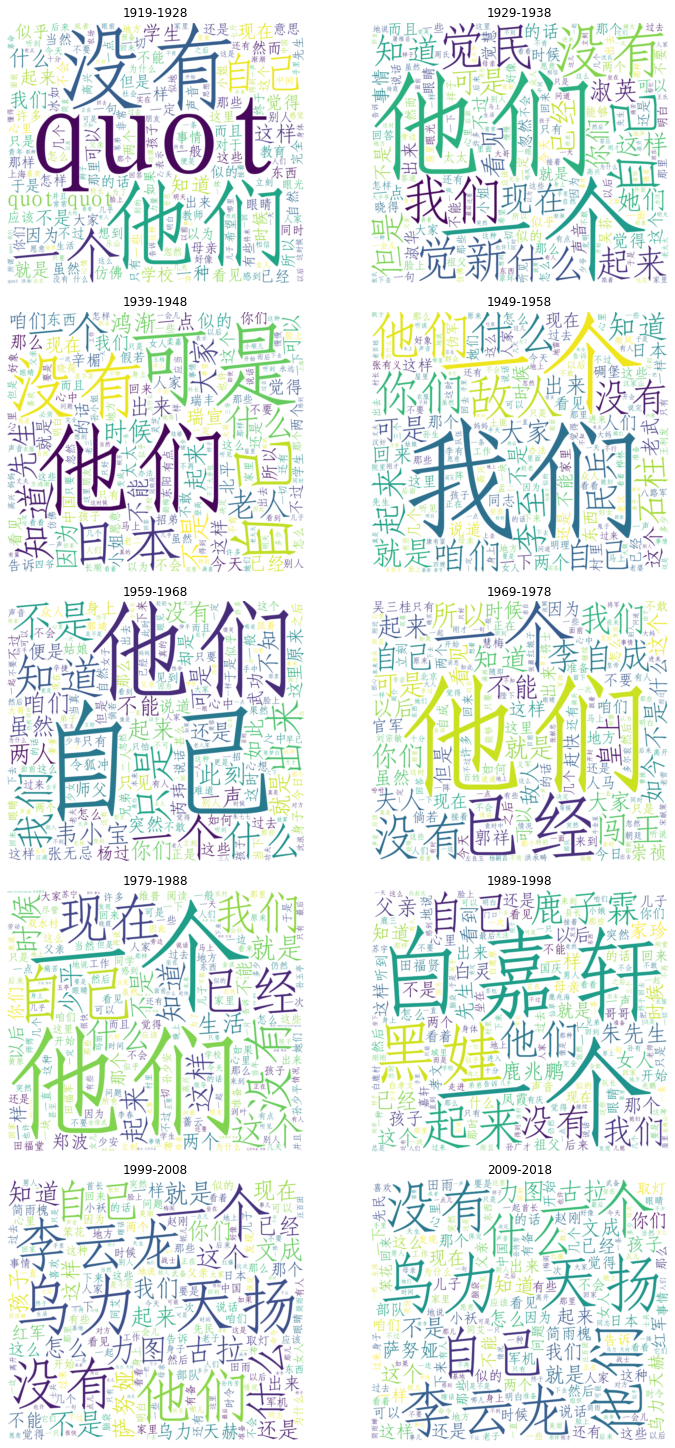

In [0]:
years2cloud = {}
for key, value in years2text.items():
    years2cloud[key] = ''
    for i in value:
        years2cloud[key] += i 

figsize = (10,20)
fig, axs = plt.subplots(5,2, figsize=figsize, constrained_layout=True)
key = sorted(years2cloud)
index = 0
for row in axs:
    for ax in row:
        wordcloud = WordCloud(
        font_path="simfang.ttf",
        background_color="white",width=1000,height=880).generate(years2cloud[key[index]])
        ax.set_title(key[index])
        index += 1 
        ax.axis("off")
        ax.imshow(wordcloud, interpolation="bilinear")
plt.show()

分析上面的图，不管是什么时代，“一个”“我们”“自己”等日常常用词汇都在文学作品中占有非常高的频率，除去这些日常用词，从时代背景去分析，我们还可以得到以下几个信息：  
* 1939-1948中“日本”出现的频率较高，中国此时正值反侵略战争的时期，中国的文学作家此时也在作品中为斗争作出贡献。
* 1949-1958中“敌人”出现的频率较高，刚成立的新中国依然面对着诸多困难与敌人，此期间的重要事件：抗美援朝。[新中国成立10年我国主要事件](https://zhidao.baidu.com/question/2208490922439343748.html)
* 其他时期有许多人名的出现频率比较高，比如觉新，李自成，李云龙等，大部分是数据集本身的特征，在这里不做分析。

4. **随着经济发展（年份变化），观察近一百年来文学作品中全国各省份地点的出现频率发生怎样的变化。也许经济越发达的省份，在文化作品中出现的频率也越高，增长速度也越快。以收集到的文学作品为数据，一百年为总体，每十年为一个样本**

In [0]:
# 城市字典
cities = {
'台湾':
['台北', '高雄', '基隆', '台中', '台南', '新竹', '嘉义'],
'重庆':
[],
'河南':
['郑州', '开封', '洛阳', '平顶山', '安阳', '鹤壁', '新乡', '焦作', '济源', '濮阳', '许昌', '漯河', '三门峡', '南阳', '商丘', '信阳', '周口', '驻马店'],
'青海':
['西宁', '海东', '海北藏族', '黄南藏族', '海南藏族', '果洛藏族', '玉树藏族', '海西蒙古族藏族'],
'辽宁':
['沈阳', '大连', '鞍山', '抚顺', '本溪', '丹东', '锦州', '营口', '阜新', '辽阳', '盘锦', '铁岭', '朝阳', '葫芦岛'],
'四川':
['成都', '自贡', '攀枝花', '泸州', '德阳', '绵阳', '广元', '遂宁', '内江', '乐山', '南充', '眉山', '宜宾', '广安', '达州', '雅安', '巴中', '资阳', '阿坝藏族羌族', '甘孜藏族', '凉山彝族'],
'河北':
['石家庄', '唐山', '秦皇岛', '邯郸', '邢台', '保定', '张家口', '承德', '沧州', '廊坊', '衡水'],
'宁夏':
['银川', '石嘴山', '吴忠', '固原', '中卫'],
'湖北':
['武汉', '黄石', '十堰', '宜昌', '襄樊', '鄂州', '荆门', '孝感', '荆州', '黄冈', '咸宁', '随州', '恩施土家族苗族', '仙桃', '潜江', '天门', '神农架'],
'海南':
['海口', '三亚', '五指山', '琼海', '儋州', '文昌', '万宁', '东方'],
'天津':
[],
'云南':
['昆明', '曲靖', '玉溪', '保山', '昭通', '丽江', '思茅', '临沧', '楚雄彝族', '红河哈尼族彝族', '文山壮族苗族', '西双版纳傣族', '大理白族', '德宏傣族景颇族', '怒江傈僳族', '迪庆藏族'],
'甘肃':
['兰州', '嘉峪关', '金昌', '白银', '天水', '武威', '张掖', '平凉', '酒泉', '庆阳', '定西', '陇南', '临夏回族', '甘南藏族'],
'香港':
[],
'吉林':
['长春', '吉林', '四平', '辽源', '通化', '白山', '松原', '白城', '延边朝鲜族'],
'广西':
['南宁', '柳州', '桂林', '梧州', '北海', '防城港', '钦州', '贵港', '玉林', '百色', '贺州', '河池', '来宾', '崇左'],
'陕西':
['西安', '铜川', '宝鸡', '咸阳', '渭南', '延安', '汉中', '榆林', '安康', '商洛'],
'江西':
['南昌', '景德镇', '萍乡', '九江', '新余', '鹰潭', '赣州', '吉安', '宜春', '抚州', '上饶'],
'新疆':
['乌鲁木齐', '克拉玛依', '吐鲁番', '哈密', '昌吉回族', '博尔塔拉蒙古', '巴音郭楞蒙古', '阿克苏', '克孜勒苏柯尔克孜', '喀什', '和田', '伊犁哈萨克', '塔城', '阿勒泰', '石河子', '阿拉尔', '图木舒克', '五家渠'],
'澳门':
[],
'浙江':
['杭州', '宁波', '温州', '嘉兴', '湖州', '绍兴', '金华', '衢州', '舟山', '台州', '丽水'],
'北京':
[],
'山东':
['济南', '青岛', '淄博', '枣庄', '东营', '烟台', '潍坊', '济宁', '泰安', '威海', '日照', '莱芜', '临沂', '德州', '聊城', '滨州', '菏泽'],
'江苏':
['南京', '无锡', '徐州', '常州', '苏州', '南通', '连云港', '淮安', '盐城', '扬州', '镇江', '泰州', '宿迁'],
'西藏':
['拉萨', '昌都', '山南', '日喀则', '那曲', '阿里', '林芝'],
'黑龙江':
['哈尔滨', '齐齐哈尔', '鸡西', '鹤岗', '双鸭山', '大庆', '伊春', '佳木斯', '七台河', '牡丹江', '黑河', '绥化', '大兴安岭'],
'山西':
['太原', '大同', '阳泉', '长治', '晋城', '朔州', '晋中', '运城', '忻州', '临汾', '吕梁'],
'内蒙古':
['呼和浩特', '包头', '乌海', '赤峰', '通辽', '鄂尔多斯', '呼伦贝尔', '巴彦淖尔', '乌兰察布'],
'福建':
['福州', '厦门', '莆田', '三明', '泉州', '漳州', '南平', '龙岩', '宁德'],
'湖南':
['长沙', '株洲', '湘潭', '衡阳', '邵阳', '岳阳', '常德', '张家界', '益阳', '郴州', '永州', '怀化', '娄底', '湘西土家族苗族'],
'安徽':
['合肥', '芜湖', '蚌埠', '淮南', '马鞍山', '淮北', '铜陵', '安庆', '黄山', '滁州', '阜阳', '宿州', '巢湖', '六安', '亳州', '池州', '宣城'],
'贵州':
['贵阳', '六盘水', '遵义', '安顺', '铜仁', '黔西南布依族苗族', '毕节', '黔东南苗族侗族', '黔南布依族苗族'],
'上海':
[],
'广东':
['广州', '韶关', '深圳', '珠海', '汕头', '佛山', '江门', '湛江', '茂名', '肇庆', '惠州', '梅州', '汕尾', '河源', '阳江', '清远', '东莞', '中山', '潮州', '揭阳', '云浮']}

In [0]:
# 一个字典：将地区/省份映射省份
city_map = {}
for key, value in cities.items():
    if len(value) == 0:
        city_map[key] = key
        continue
    for i in value:
        city_map[i] = key
city_map['黔东南苗族侗族'], city_map['北京']

('贵州', '北京')

In [0]:
# 统计各个时间段的地区出现频次
## 一个储存频次的字典，{"年份":{"省份"："频次",...}}
provinces_freq = {}
for year, texts in tqdm(years2text.items()):
    #  初始化计数器
    provinces_freq_year = {}
    for key, value in cities.items():
        provinces_freq_year[key] = 0
    # 统计
    for text in texts:
        words = text.split(' ')
        for word in words:
            if word in city_map:
                provinces_freq_year[city_map[word]] += 1
    provinces_freq[year] = provinces_freq_year

100%|██████████| 10/10 [00:04<00:00,  1.23it/s]


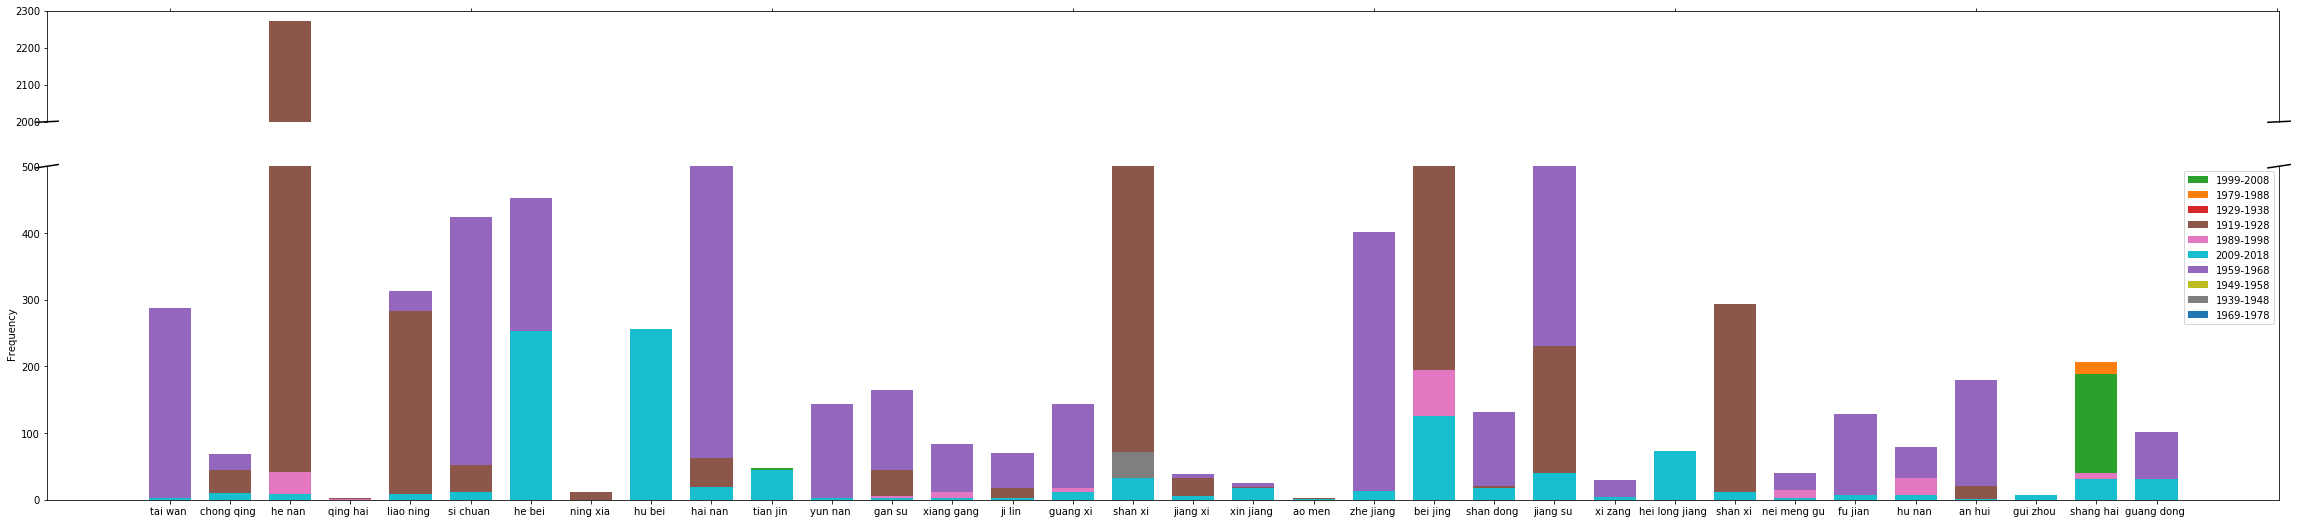

In [0]:
# 可视化
matplotlib.rcParams['image.cmap'] = 'jet'
width = 0.7     # the width of the bars: can also be len(x) sequence
plts = []
years = []
x = [lazy_pinyin(city, style=eval('Style.{}'.format('NORMAL'))) for city, _ in cities.items()]
new_x = []
for i in x:
    new_i = ''
    for j in i:
        new_i += j
        new_i += ' '
    new_x.append(new_i)
x = new_x
ind = np.arange(len(x))  # the x locations for the groups

fig = plt.figure(figsize=(40,9))
gs = GridSpec(2, 1, height_ratios=[1, 3])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
proveince = []
for year in sorted(provinces_freq):
    counts = provinces_freq[year]
    height = [freq for province, freq in counts.items()]
    p_year = ax1.bar(ind, height, width)
    p_year = ax2.bar(ind, height, width)
    plts.append(p_year[0])
    years.append(year)
# p1 = plt.bar(ind, menMeans, width, yerr=menStd)
# p2 = plt.bar(ind, womenMeans, width,
#              bottom=menMeans, yerr=womenStd)
ax1.set_ylim(2000, 2300)  # outliers only
ax2.set_ylim(0, 500)  # most of the data

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .005  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.ylabel('Frequency')
#ax1.title('miaomiaomiao~')
plt.xticks(ind, x)
#plt.title('文学作品中各省市百年来出现频率一览')
ax2.legend(set(plts), set(years))
plt.show()

In [83]:
from pyecharts.commons.utils import JsCode

from pyecharts import options as opts
from pyecharts.charts import Bar, BMap, Grid, Map, Page, Pie, Sankey, Timeline
from pyecharts.faker import Collector, Faker

tl = Timeline()
provinces_freq
for year, counter in provinces_freq.items():
    provinces = []
    for province, freq in counter.items():
        provinces.append(province)
    break
for year in sorted(provinces_freq):
    counter = provinces_freq[year]
    data = [counter[province] for province in provinces]
    bar = (
        Bar()
        .add_xaxis(provinces)
        .add_yaxis('出现频次(部分省市未出现在x轴上，请直接点击条形柱获取信息)',data)
        .set_global_opts(title_opts=opts.TitleOpts("时间段：{}".format(year)))
    )
    tl.add(bar, "{}年".format(year))
tl.render('1.html')

'/content/1.html'

In [84]:
import IPython
IPython.display.HTML(filename='/content/1.html')

In [0]:
from google.colab import files
files.download('/content/1.html')

In [267]:
# 生成动态html
from pyecharts import options as opts
from pyecharts.charts import Map, Page

total = {}
for year, counts in provinces_freq.items():
    for province, data in counts.items():
        total[province] = 0
    break
    
for year, counts in provinces_freq.items():
    for province, data in counts.items():
        total[province] += data
provinces = []
values = []
for province, value in total.items():
    provinces.append(province)
    values.append(value)

c = (
    Map()
    .add("文学作品省份/市出现频次", [list(z) for z in zip(provinces, values)], "china")
    .set_global_opts(
        title_opts=opts.TitleOpts(title=""),
        visualmap_opts=opts.VisualMapOpts(max_=2000),
    )
)
c.render('2.html')

'/content/2.html'

In [268]:
import IPython
IPython.display.HTML(filename='/content/2.html')

由上图可分析得知：
* 从时间维度上看，大部分省份/城市的名称极速增长的时间段为紫色对应的1949-1958，棕色对应的1919-1928，再其次就是青色对应的1979-1988，至于为什么这些时间段的文学作品大量出现省份/城市名，猜测为这时期的战争以及改革开放时代背景，相关题材的作品会部分反映人口流动的情况。特别的，台湾在1949-1958年大量出现。
* 从省份上说，规律比较难以寻找。不过上海非常特别，其频次的快速增长时期不同与上面所说，其在1989-1998以及2009-2018年中增长较快。可能与其作为中国经济最发达的地区有关。回到经济上，大部分经济发达的地区的确拥有较高的频次，不过广东香港的频次比较低。

In [0]:
# 假设检验
# 以“北京市”出现的频次的平均数为统计量，检验样本2009-2019年这十年“北京市”出现的平均数与总体平均数是否有差异,a=0.05
from numpy import sqrt, abs, round
from scipy.stats import norm
total = sum(values)
mean = total / len(provinces)
data = []
for year in sorted(provinces_freq):
    counts = provinces_freq[year]
    height = [freq for province, freq in counts.items()]
    data.extend(height)
data = np.array(data)
var = np.var(data)
beijing_2009_2019 = provinces_freq['2009-2018']['北京']
def OneSampZ(X, mu, var, n):
    return (X - mu)/(sqrt(var)/sqrt(n))

z = OneSampZ(beijing_2009_2019, mean, var, len(provinces)*10)
print("z值为{}, 大于临界值1.645，故拒绝原假设，即有差异。".format(abs(z)))

z值为37.223818702718084, 大于临界值1.645，故拒绝原假设，即有差异。


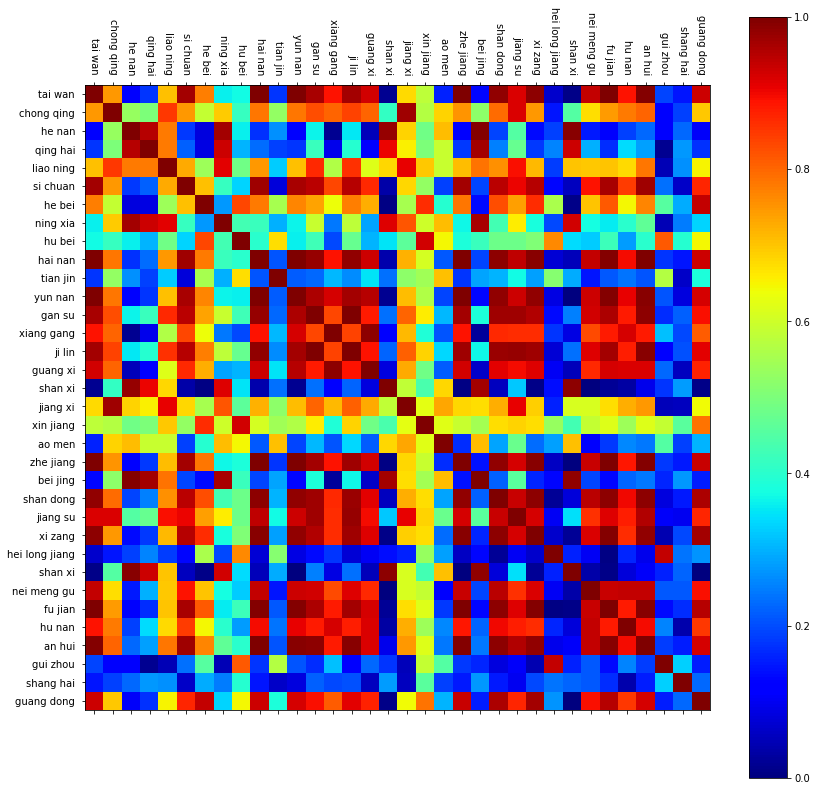

In [0]:
# 相关分析：以各省市每十年出现的频次的平均数为统计量，探究在一百年文学作品中出现的频次各省市之间是否存在相关关系
# 使用皮尔逊积矩相关系数（Pearson's）
datas = []
provinces = []
for year in sorted(provinces_freq):
    counts = provinces_freq[year]
    for province, count in counts.items():
        provinces.append(province)
    break
for province in provinces:
    data = []
    for year in sorted(provinces_freq):
        counts = provinces_freq[year]
        data.append(counts[province])
    datas.append(data)
datas = np.array(datas)
correlation_matrix = np.corrcoef(datas)

fig, ax = plt.subplots(figsize=(14,14))
hot_img = ax.matshow(np.abs(correlation_matrix), vmin=0, vmax=1) 


fig.colorbar(hot_img)
ticks = np.arange(0, len(provinces), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(x)
ax.set_yticklabels(x)
plt.setp(ax.get_xticklabels(), rotation=270)
#plt.title('Pearson\'s r')
plt.show()

In [112]:
import random

from pyecharts import options as opts
from pyecharts.charts import HeatMap, Page
from pyecharts.faker import Collector, Faker

corr = np.abs(correlation_matrix)
value = [[i, j, corr[i][j]*100] for i in range(len(provinces)) for j in range(len(provinces))]
c = (
    HeatMap()
    .add_xaxis(provinces)
    .add_yaxis("相关系数(0-100)", provinces, value)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="各省市之间频次相关系数"),
        visualmap_opts=opts.VisualMapOpts(),
    )
)

c.render('3.html')

'/content/3.html'

In [113]:
import IPython
IPython.display.HTML(filename='/content/3.html')

上图所示的相关性矩阵是一个对称矩阵，因此我们只需要分析上半/下半矩阵。按行考察（右边开头到对角线），可以看出，山西，黑龙江，陕西，贵州和上海颜色偏冷，也即其与其他各省市的相关性比较低。内蒙古，福建和湖南与其他省市相关性叫高，有着大片的红色区域。至于该现象出现的原因暂无合理归因。

In [0]:
# 方差分析：北上广
from scipy import stats 
def get_province_data(name):
    data = []
    for year in sorted(provinces_freq):
        counts = provinces_freq[year]
        data.append(counts[name])
    return data
beijing = get_province_data('北京')
shanghai = get_province_data('上海')
guangdong = get_province_data('广东')

f,p = stats.f_oneway(beijing, shanghai, guangdong)
print("p值为{}>0.05,数据的差异无统计学意义。".format(p))

p值为0.16142716666656337>0.05,数据的差异无统计学意义。


In [0]:
# 复杂网络
import json
import os

from pyecharts.commons.utils import JsCode
from pyecharts import options as opts
from pyecharts.charts import Graph, Page, Timeline
from pyecharts.faker import Collector

import random
def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color
nodes = []
links = []
provinces_index = {}
for i in provinces:
    nodes.append({"name": i, "symbolSize": 40, "itemStyle": {"normal": {"color": randomcolor()}},})
for i in provinces:
    dicts = bigram.vocabulary_
    for key, value in dicts.items():
        key1, key2 = key.split(' ')
        if key1 == i:
            nodes.append({"name": key2, "symbolSize": random.randint(15,30), "itemStyle": {"normal": {"color": randomcolor()}},})
            links.append(opts.GraphLink(source=i, target=key2, value=2))
        if key2 == i:
            nodes.append({"name": key1, "symbolSize": random.randint(15,30), "itemStyle": {"normal": {"color": randomcolor()}},})
            links.append(opts.GraphLink(source=i, target=key1, value=2))

In [264]:
c = (
    Graph()
    .add("", nodes[:100], links[:110], repulsion=8000)
    .set_global_opts(title_opts=opts.TitleOpts(title="复杂网络(并不)"))
)
c.render('4.html')

'/content/4.html'

In [265]:
import IPython
IPython.display.HTML(filename='/content/4.html')

最多只能显示100个节点。